# Plot the landscape

This notebook loads the information stored in the `landscape_info.pkl` and `annotations_info.pkl` files 
and visualises different aspects of the speaker landscapes. Some of the techniques also need to load the word embedding from ``word_embedding.emb``. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.lines import Line2D
from gensim.models import KeyedVectors
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

## 1. Load information

In [ ]:
df = pd.read_pickle("landscape_info.pkl")

In [3]:
df_annotations = pd.read_pickle("annotations_info.pkl")

In [4]:
speakers = df["author"].tolist()
speakers_positions = df["low_dim_vec"].tolist()

annotations = df_annotations["word"].to_list()[:10]
annotations_positions = df["low_dim_vec"].tolist()[:10]

## 2. Plot annotated landscape

In [ ]:
fig = go.Figure(data=go.Scatter(x=df['Postal'],
                                y=df['Population'],
                                mode='markers',
                                marker_color='lightgray',
                                text=data['State']))

fig.update_layout(title='Population of USA States')
fig.show()

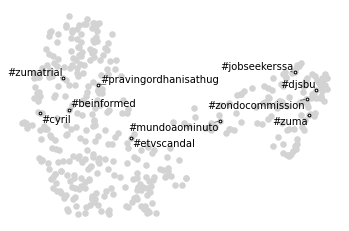

In [5]:
fig = plt.figure()

plt.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=30, c="lightgray")

texts = []
for i, word in enumerate(annotations):
    texts.append(plt.text(annotations_positions[i][0], annotations_positions[i][1], word, fontsize=10, color="black"))
adjust_text(texts, [a[0] for a in annotations_positions], [a[1] for a in annotations_positions], arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
plt.scatter([a[0] for a in annotations_positions], [a[1] for a in annotations_positions], s=30, marker='.', facecolors=(1,1,1,1), edgecolors=(0, 0, 0, 1), zorder=4)

plt.axis("off")
plt.show()

## 3. Inspect tweets of authors in a region of the landscape

To investigate the tweets posted by speakers located in different regions of the landscape, we pick a point, find the speakers around that point and inspect their tweets.

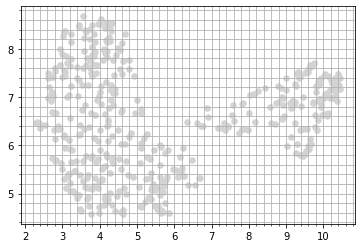

In [6]:
# Look at the 2d landscape in a coordinate system, so we can define a point.

plt.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=30, c="lightgray")
plt.minorticks_on()
plt.grid(which="both")
plt.show()

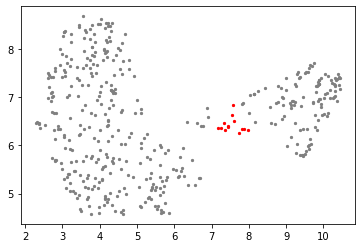

In [17]:
point=np.array([7.5, 6])  # use the coordinate grid above to choose the point you want to pick a neuughbourhood from
radius=1 # maximum cosine distance between the point and the 2d agent vector

fig = plt.figure()

# get agents around the point
indices = []
for i, v in enumerate(speakers_positions):
    distance = np.sum(np.abs(speakers_positions[i]- point))
    if distance < radius:
        indices.append((i, distance))

sorted_indices = sorted(indices, key= lambda pair: pair[1], reverse=True)
sorted_indices = [s[0] for s in sorted_indices]
close_agents = [speakers[i] for i in sorted_indices]

indices = [speakers.index(agent) for agent in close_agents]
marked = [speakers_positions[i] for i in range(len(speakers_positions)) if i in indices]
unmarked = [speakers_positions[i] for i in range(len(speakers_positions)) if i not in indices]
plt.scatter([p[0] for p in unmarked], [p[1] for p in unmarked], s=5, c="gray")
plt.scatter([p[0] for p in marked], [p[1] for p in marked], s=5, c="red")

plt.show()

In [18]:
# Print speakers and their tweets. They are ordered according to their distance to the chosen point.

closest = df[df["author"].isin(close_agents)]
for _, row in closest.iterrows():
    print(row["author"])
    for q in row["quotes"]:
        print( "--", q)
    print()

agent__stormhaze
-- @nolomolekwa ba khona abo buthelezi and even zuma 😮🙆🏽‍♂️
-- @nolomolekwa ba khona abo buthelezi and even zuma 😮🙆🏽‍♂️

agent_alfien93568801
-- urgent dr nkosazana dlamini zuma invites you to comment on the covid19 vaccine injury nofault compensation scheme click to have your say httpstcozxstjuebyu
-- urgent dr nkosazana dlamini zuma invites you to comment on the covid19 vaccine injury nofault compensation scheme click to have your say httpstcozxstjuebyu

agent_boycottuline
-- @andy_olsen @thedailybeast use zuma office supply or grainger instead zuma donates half their annual profits to charity and grainger carries industrial and office supplies
-- @dcclothesline @uline donated to politicians who denied biden won the election and funded voices behind the capitol riot they donated 68 million dollars to republican extremists in 2020 alone use zuma office supply they donate half their profits to charity every year httpstco2vt0dev5lk
-- @andy_olsen @thedailybeast use zuma

## 4. Projection to anger

In [9]:
anger_words = ["fuck", "shit", "fucking", "damn", "asshole", "assholes" "fucker", "bloody", "stupid", 
               "gun", "will", "murder", "kill", "violence", "wrong",
               "shoot", "bad", "death", "attack", "feel", "shot", "action",
               "arm", "idiot", "crazy", "criminal", "terrorist", "mad", "hell",
               "crime", "blame", "fight", "ridicule", "insane", "die",
               "threat", "terror", "hate"] 

embedding = KeyedVectors.load("word_embedding.emb")
vocab = embedding.index_to_key

# remove anger words that are not in the embedding's vocab (since they were not in the text corpus)
not_in_vocab = [word for word in anger_words if word not in vocab]
anger_words = [word for word in anger_words if word not in not_in_vocab]
anger_words

['fuck',
 'shit',
 'damn',
 'stupid',
 'will',
 'kill',
 'violence',
 'wrong',
 'bad',
 'attack',
 'feel',
 'action',
 'idiot',
 'crazy',
 'criminal',
 'hell',
 'blame',
 'fight',
 'ridicule',
 'die',
 'hate']

In [10]:
projections_anger = []

for speaker in speakers:
    distances = []
    for anger_word in anger_words:
        distances.append(np.dot(embedding[speaker], embedding[anger_word]))
    projections_anger.append(np.mean(distances))
    
# we standarise the values...
mean = np.mean(projections_anger)
projections_anger = [x-mean for x in projections_anger]
# and overemphasise extremes with a nonlinear function
projections_anger = [np.tanh(7*x) for x in projections_anger]

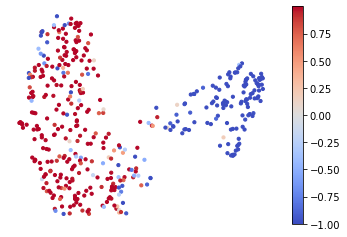

In [11]:
fig, ax1 = plt.subplots(1, 1)
plot = ax1.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=10, 
                   cmap="coolwarm", c=projections_anger, vmin=min(projections_anger), vmax=max(projections_anger))
ax1.axis("off")
fig.colorbar(plot)

## 5. Tweet length

In [12]:
speaker_tweets = df.quotes.to_list()
lengths = [np.mean([len(t) for t in tweets]) for tweets in speaker_tweets]

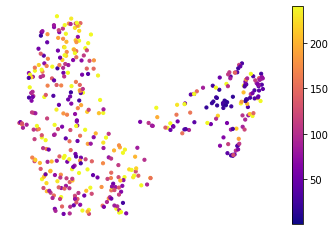

In [13]:
fig, ax1 = plt.subplots(1, 1)
plot = ax1.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=10, 
                   cmap="plasma", c=lengths, vmin=1, vmax=240)
ax1.axis("off")
fig.colorbar(plot)

## 6. Emoji count

In [14]:
from emoji import UNICODE_EMOJI
import emoji
import re

In [15]:
speaker_tweets = df.quotes.to_list()
average_num_emojis = [np.mean([len(re.findall(u'[\U0001f600-\U0001f999]', t)) for t in tweets]) for tweets in speaker_tweets]

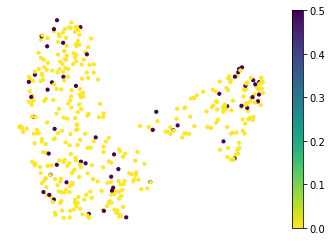

In [16]:
fig, ax1 = plt.subplots(1, 1)
plot = ax1.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=10, 
                   cmap="viridis_r", c=average_num_emojis, vmin=0, vmax=0.5)
ax1.axis("off")
fig.colorbar(plot)